In [1]:
using Pkg; Pkg.activate(".")

Activating environment at `~/work/hubblehunter/Project.toml`


In [2]:
using Cosmology
using Cosmology: integrate, find_zero
using PyPlot
using JLD2
using Dierckx: Spline1D
using DelimitedFiles
using Setfield
using SelfFunctions

┌ Info: Recompiling stale cache file /home/marius/.julia/compiled/v1.2/Cosmology/REPw9.ji for Cosmology [2b3c750e-bc73-11e8-3d6c-0d23c334b2a7]
└ @ Base loading.jl:1240
┌ Warning: Replacing docs for `Cosmology.η :: Union{}` in module `Cosmology`
└ @ Base.Docs docs/Docs.jl:223
┌ Warning: Replacing docs for `Cosmology.τ :: Union{}` in module `Cosmology`
└ @ Base.Docs docs/Docs.jl:223
┌ Warning: Replacing docs for `Cosmology.τdrag :: Union{}` in module `Cosmology`
└ @ Base.Docs docs/Docs.jl:223


In [3]:
p = new_params(H0=67.36, ωb=0.02237, ωc=0.12, mν=0.06eV, Nν_massive=1., Nν_massless=2.046, reltol=1e-4)
p = Cosmology.precompute_ρνmassive(p);

In [4]:
# by how much to change H0 to decrease DA(z*) by  0.5% ?
@self Params DA2hubble!(DA′) = Cosmology.find_zero((H0′->(H0=H0′; init_background!(); init_reio!(); DA(zstar())-DA′)), 20, 200)
DA2hubble!(p, DA(p,zstar(p))*0.995).H0 / p.H0 - 1

0.026112571679204777

In [5]:
@self Params gvis(z) = ⅆτ_ⅆz(z) * exp(-τ(z))

gvis (self function of type Params)

In [6]:
z = 10 .^ range(5,1,length=512);

In [7]:
@self Params ⅆrsvis_ⅆlnH_term1(z) = (exp(-τ(z))-1) * ⅆrs_ⅆz(z)
@self Params ⅆrsvis_ⅆlnH_term2(z) = -gvis(z)*rs(z)
@self Params ⅆrsvis_ⅆlnH_term3(z) = ⅆτ_ⅆz(z) * integrate(z′->gvis(z′)*rs(z′), z, Inf)

@self Params ⅆrsvis_ⅆlnH(z) = ⅆrsvis_ⅆlnH_term1(z) + ⅆrsvis_ⅆlnH_term2(z) + ⅆrsvis_ⅆlnH_term3(z)

ⅆrsvis_ⅆlnH (self function of type Params)

In [8]:
@self Params ⅆexprdeffr²_ⅆlnH_term1(z,r) = (1-exp(-τ(z))) * exp(-(rd(z)/r)^2)/r^2 * ⅆrd²_ⅆz(z)
@self Params ⅆexprdeffr²_ⅆlnH_term2(z,r) = -gvis(z)*exp(-(rd(z)/r)^2)
@self Params ⅆexprdeffr²_ⅆlnH_term3(z,r) = ⅆτ_ⅆz(z) * integrate(z′->gvis(z′)*exp(-(rd(z′)/r)^2), z, Inf)

@self Params ⅆexprdeffr²_ⅆlnH(z,r) = ⅆexprdeffr²_ⅆlnH_term1(z,r) + ⅆexprdeffr²_ⅆlnH_term2(z,r) + ⅆexprdeffr²_ⅆlnH_term3(z,r)

ⅆexprdeffr²_ⅆlnH (self function of type Params)

In [9]:
rsvis = rs_vis(p);

In [10]:
αrs = 1/rsvis;

In [11]:
@time drs = αrs * ⅆrsvis_ⅆlnH.(p,z);

 37.028782 seconds (581.55 M allocations: 9.157 GiB, 4.70% gc time)


In [12]:
@time drs′ = αrs * ⅆrsvis_ⅆlnH_term1.(p,z);

  0.114032 seconds (714.22 k allocations: 15.689 MiB)


In [13]:
14000 * π/1500

29.321531433504735

In [14]:
r₀ = 14000 * π/1500 * Mpc

5.597977538383105e58

In [15]:
r₀ = 30Mpc;

In [16]:
rdeff = rd_vis(p,r₀);

In [17]:
αrd = (exp(-(rdeff/r₀)^2) * (-2/r₀^2) * rdeff^2)^-1;

In [18]:
@time drd = αrd * ⅆexprdeffr²_ⅆlnH.(p,z,r₀);

 21.222943 seconds (304.21 M allocations: 4.729 GiB, 4.56% gc time)


In [19]:
@time drd′ = αrd * ⅆexprdeffr²_ⅆlnH_term1.(p,z,r₀);

  0.328961 seconds (3.74 M allocations: 62.394 MiB, 5.36% gc time)


In [20]:
Hz_ϕ4 = Spline1D(eachcol(readdlm("dat/Phi4_TEfull_BAOhlz_Lens_H0_Pant_bf_background.dat",comments=true)[end:-1:1,[1,4]])...);

In [21]:
rc("patch", linewidth=1.5)
to_rgba = plt.matplotlib.colors.to_rgba;

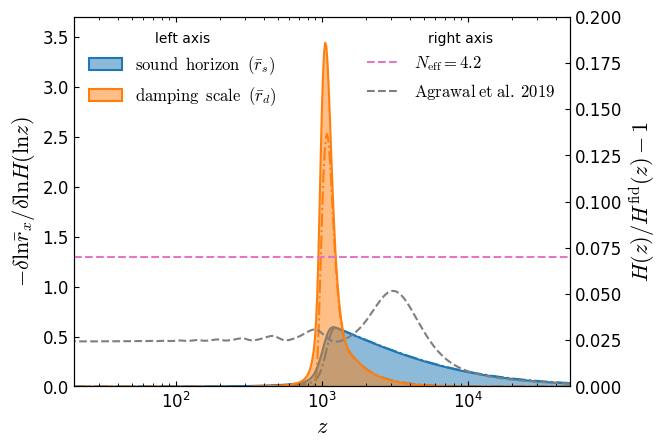

In [22]:
fill_between(z, 0, -z .* drs, edgecolor="C0", facecolor=to_rgba("C0",0.5), label=raw"${\rm sound\;\;horizon} \;\;(\bar r_s)$")
semilogx(z, -z .* drs′, c="C0", ls="-.", zorder=-100)

fill_between(z, 0, -z .* drd, edgecolor="C1", facecolor=to_rgba("C1",0.5), label=raw"${\rm damping\;\;scale} \;\;(\bar r_d)$")
semilogx(z, -z .* drd′, c="C1", ls="-.", zorder=-100)

legend(title="left axis", loc="upper left")

ylim(0,3.7)
xlim(2e1,5e4)
xlabel(raw"$z$")
ylabel(raw"$-\delta \ln \bar r_x / \delta \ln H(\ln z)$")

twinx()



plot(xlim(), fill(0.07,2), "C6--", label=raw"$N_{\rm eff}=4.2$")
plot(z, Hz_ϕ4.(z) ./ (Hubble.(p,z)*Mpc) .- 1, "C7--", label=raw"$\rm Agrawal\; et\; al.\; 2019$")

legend(title="right axis", loc="upper right")

# xscale("linear")
# xlim(50,20000)

ylim(0,0.2)
ylabel(raw"$H(z) / H^{\rm fid}(z)-1$")

savefig("paper/Figures/rs_rd.pdf", bbox_inches="tight")